In [36]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import os


In [37]:
import numpy as np
import pandas as pd
import datetime as dt


# Reflect Tables into SQLAlchemy ORM

In [38]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func


In [39]:
# Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [40]:
# Declare a Base using `automap_base()`
base=automap_base()

# Use the Base class to reflect the database tables
base.prepare(engine, reflect=True)


C:\Users\wware\AppData\Local\Temp\ipykernel_14160\3097979872.py:5: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  base.prepare(engine, reflect=True)


In [41]:
# Print all of the classes mapped to the Base
print(base.classes.keys())

['measurement', 'station']


In [42]:
# Assign the measurement class to a variable called `Measurement`
Measurement=base.classes.measurement

# Assign the station class to a variable called `Station`
Station=base.classes.station


In [43]:
# Create a session
session = Session(engine)

# Exploratory Precipitation Analysis

In [44]:
# Find the most recent date in the data set.
date_most_recent=session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
date_most_recent

'2017-08-23'

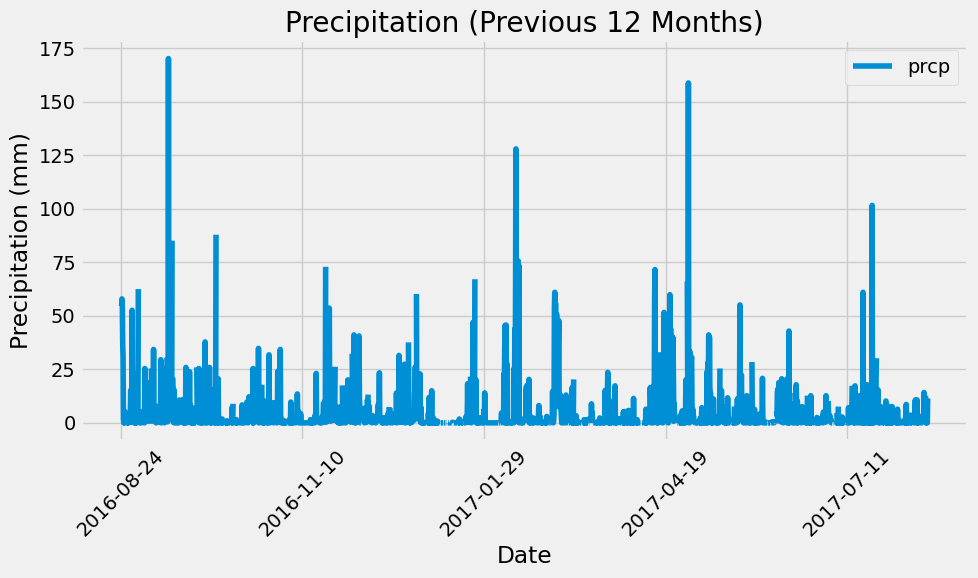

In [48]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database.

# Calculate the date one year from the last date in data set.
date_one_year_ago=dt.datetime.strptime(date_most_recent, "%Y-%m-%d")-dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation=session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= date_one_year_ago).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df=pd.DataFrame(precipitation, columns=["date", "prcp"])

# Sort the dataframe by date
precipitation_df=precipitation_df.sort_values("date")

# Create the Outputs directory
output_dir = 'Outputs'

# Define the output file path
output_file = os.path.join(output_dir, 'precipitation_plot.png')

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(x="date", y="prcp", figsize=(10,6), title='Precipitation (Previous 12 Months)')
plt.xlabel("Date")
plt.ylabel("Precipitation (mm)")
plt.xticks(rotation=45)
plt.tight_layout()

# Save the plot to the specified file
plt.savefig(output_file)

plt.show()


In [49]:
# Use Pandas to calculate the summary statistics for the precipitation data
stats_summary=precipitation_df.describe()
stats_summary

,prcp
count,2015.000000
mean,4.485112
std,11.690532
min,0.000000
25%,0.000000
50%,0.500000
75%,3.300000
max,170.200000


# Exploratory Station Analysis

In [50]:
# Design a query to calculate the total number of stations in the dataset
total_stations=session.query(Station.station).count()
total_stations

9

In [51]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations=session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

# Display the results as a DataFrame
active_stations_df=pd.DataFrame(active_stations, columns=["station", "count"])
active_stations_df.head()

,station,count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612


In [52]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station=active_stations_df.iloc[0,0]
most_active_station


'USC00519281'

In [53]:
# Calculate the lowest, highest, and average temperature for the most active station
temp_stats=session.query(
    func.min(Measurement.tobs), 
    func.max(Measurement.tobs), 
    func.avg(Measurement.tobs)
).filter(Measurement.station==most_active_station).all()

# Extract the temp stats
lowest_temp, highest_temp, avg_temp=temp_stats[0]
lowest_temp, highest_temp, avg_temp

(12.2, 29.4, 22.035822510822513)

In [54]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
total_obs_active_station=session.query(Measurement.tobs).\
    filter(Measurement.station==most_active_station).\
    filter(Measurement.date >= date_one_year_ago).all()

total_obs_active_station_df=pd.DataFrame(total_obs_active_station, columns=["tobs"])

total_obs_active_station_df.head()

,tobs
0,25.0
1,26.7
2,26.7
3,23.9
4,22.8


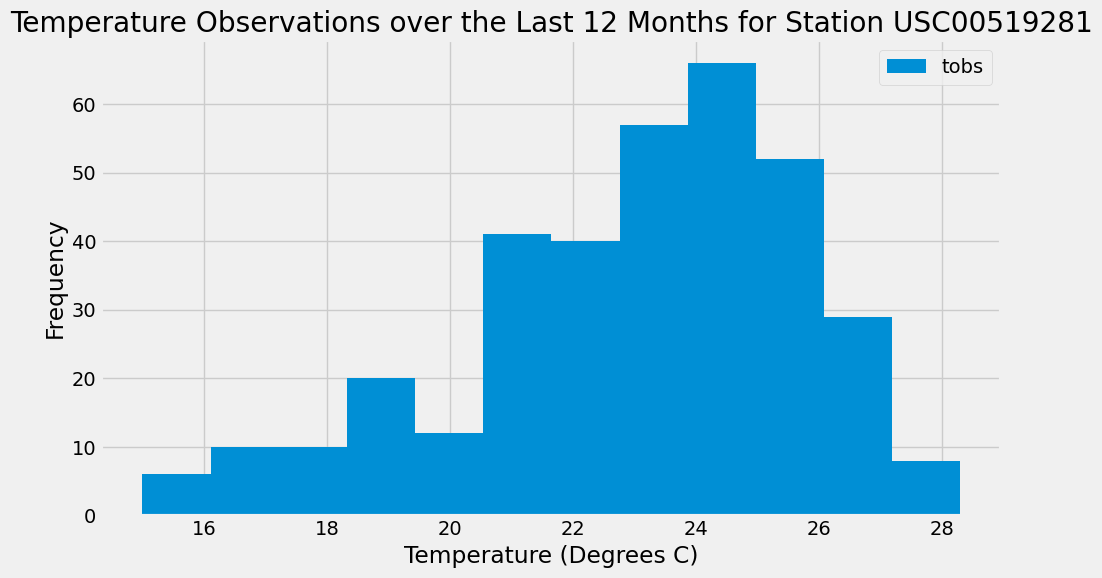

In [56]:
# Create the Outputs directory
output_dir = 'Outputs'

# Define the output file path
output_file = os.path.join(output_dir, f'precipitation_hist for {most_active_station}.png')


# Plot the results as a histogram
total_obs_active_station_df.plot.hist(bins=12, figsize=(10,6),title='Temperature Observations (Previous 12 Months)')
plt.title(f'Temperature Observations over the Last 12 Months for Station {most_active_station}')
plt.xlabel('Temperature (Degrees C)')
plt.ylabel('Frequency')
plt.tight_layout()

# Save the plot to the specified file
plt.savefig(output_file)

plt.show()



# Close Session

In [57]:
# Close Session
session.close()
